In [1]:
# === BYOL Part 0: Install deps ===

# deps
!pip -q install lightly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# === BYOL Part 1: Setup & Config ===

import os, math, random, numpy as np
from tqdm import tqdm

import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Lightly BYOL bits
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.utils.scheduler import cosine_schedule

# --- toggles / paths ---
DATA_DIR = '/kaggle/input/riceds-original/Original'
SAVE_DIR = './'
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True; cudnn.benchmark = False

# --- BYOL pretrain ---
BYOL_EPOCHS = 100
BYOL_LR = 3e-4
BYOL_WEIGHT_DECAY = 1e-6
BYOL_BASE_M = 0.996      # momentum base
BATCH_SIZE = 64
NUM_WORKERS = 4

# --- Supervised finetune ---
FINETUNE_EPOCHS = 30
FT_LR_BACKBONE = 1e-4
FT_LR_HEAD = 1e-3
FT_WEIGHT_DECAY = 1e-4
USE_IMAGENET_WEIGHTS = True

# accuracy boosters
USE_MIXUP = True
MIXUP_ALPHA = 0.2
LABEL_SMOOTH = 0.0
USE_EMA = True
EMA_DECAY = 0.999
USE_TTA = True

# (optional) class balance
USE_BALANCED_SAMPLER = False  # set True if classes imbalanced

# histories
byol_loss_hist, ft_loss_hist_byol, ft_acc_hist_byol, val_acc_hist_byol = [], [], [], []

print("Device:", DEVICE)


Device: cuda


In [3]:
# === BYOL Part 2: Augmentations ===

supervised_train_tf_byol = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])
eval_tf_byol = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

# BYOL two-view transform at 224px (with blur)
byol_transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=224, gaussian_blur=1.0),
    view_2_transform=BYOLView2Transform(input_size=224, gaussian_blur=1.0),
)


In [4]:
# === BYOL Part 3: Stratified Split (t80_te20) ===

# Split preset: t80_te20 (train 80%, val 0%, test 20%)
SPLIT_SCHEMES = {
    "t80_te20":      (0.80, 0.00, 0.20),
}
SELECTED_SCHEME = "t80_te20"

_base = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
labels_all = np.array([lbl for _, lbl in _base.samples])
N = len(labels_all)

def make_stratified_indices(labels, train_p, val_p, test_p, seed=SEED):
    assert abs(train_p + val_p + test_p - 1.0) < 1e-8
    idx_all = np.arange(len(labels))
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_p+test_p), random_state=seed)
    train_idx, hold_idx = next(sss1.split(idx_all, labels))
    if val_p == 0:
        return train_idx, np.array([], dtype=int), hold_idx
    hold_labels = labels[hold_idx]
    val_share = val_p/(val_p+test_p)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(1.0 - val_share), random_state=seed)
    val_rel, test_rel = next(sss2.split(np.arange(len(hold_idx)), hold_labels))
    return train_idx, hold_idx[val_rel], hold_idx[test_rel]

trf, vlf, tef = SPLIT_SCHEMES[SELECTED_SCHEME]
train_idx_byol, val_idx_byol, test_idx_byol = make_stratified_indices(labels_all, trf, vlf, tef, seed=SEED)

print(f"Scheme {SELECTED_SCHEME} -> train {int(trf*100)}% ({len(train_idx_byol)}), "
      f"val {int(vlf*100)}% ({len(val_idx_byol)}), test {int(tef*100)}% ({len(test_idx_byol)})")


Scheme t80_te20 -> train 80% (15200), val 0% (0), test 20% (3800)


In [5]:
# === BYOL Part 4: SSL loaders (train only) ===

ssl_dataset_byol = datasets.ImageFolder(DATA_DIR, transform=byol_transform)
train_ssl_byol = Subset(ssl_dataset_byol, train_idx_byol)

train_loader_ssl_byol = DataLoader(
    train_ssl_byol, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
len(train_loader_ssl_byol), len(train_ssl_byol)


(237, 15200)

In [6]:
# === BYOL Part 5: Models ===

class EncoderBYOL(nn.Module):
    def __init__(self, use_imagenet=True):
        super().__init__()
        if use_imagenet:
            try:
                base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            except Exception:
                base = models.resnet50(pretrained=True)
        else:
            base = models.resnet50(weights=None)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # (B,2048,1,1)
        self.feature_dim = 2048
    def forward(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)

class BYOLWrapper(nn.Module):
    def __init__(self, encoder: EncoderBYOL):
        super().__init__()
        self.backbone = encoder
        self.projection_head = BYOLProjectionHead(encoder.feature_dim, 4096, 256)
        self.prediction_head = BYOLPredictionHead(256, 4096, 256)

        # momentum/target network
        self.backbone_m = EncoderBYOL(use_imagenet=True)
        self.backbone_m.load_state_dict(self.backbone.state_dict(), strict=True)
        self.projector_m = BYOLProjectionHead(encoder.feature_dim, 4096, 256)
        self.projector_m.load_state_dict(self.projection_head.state_dict(), strict=True)

        deactivate_requires_grad(self.backbone_m)
        deactivate_requires_grad(self.projector_m)

    def forward_online(self, x):
        y = self.backbone(x)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    @torch.no_grad()
    def forward_target(self, x):
        y = self.backbone_m(x)
        z = self.projector_m(y)
        return z.detach()

    @torch.no_grad()
    def update_momentum(self, m):
        update_momentum(self.backbone,           self.backbone_m,  m=m)
        update_momentum(self.projection_head,    self.projector_m, m=m)

class SupModelBYOL(nn.Module):
    def __init__(self, encoder: EncoderBYOL, num_classes: int):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(encoder.feature_dim, num_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)


In [7]:
# === BYOL Part 6: BYOL Pretraining (save encoder) ===

enc_byol = EncoderBYOL(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
byol = BYOLWrapper(enc_byol).to(DEVICE)

criterion_byol = NegativeCosineSimilarity()
opt_byol = torch.optim.AdamW(byol.parameters(), lr=BYOL_LR, weight_decay=BYOL_WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

max_steps = BYOL_EPOCHS * max(1, len(train_loader_ssl_byol))
global_step = 0

print("Starting BYOL pretraining")
for epoch in range(BYOL_EPOCHS):
    byol.train(); running = 0.0
    pbar = tqdm(train_loader_ssl_byol, desc=f"BYOL {epoch+1}/{BYOL_EPOCHS}")
    for batch in pbar:
        (x0, x1), _ = batch
        x0 = x0.to(DEVICE, non_blocking=True); x1 = x1.to(DEVICE, non_blocking=True)

        m_val = cosine_schedule(global_step, max_steps, BYOL_BASE_M, 1.0)
        byol.update_momentum(m_val)

        with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
            p0 = byol.forward_online(x0)
            z1 = byol.forward_target(x1)
            p1 = byol.forward_online(x1)
            z0 = byol.forward_target(x0)
            loss = 0.5 * (criterion_byol(p0, z1) + criterion_byol(p1, z0))

        opt_byol.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt_byol); scaler.update()

        running += float(loss.detach().item())
        global_step += 1
        pbar.set_postfix(loss=f"{running/max(1,pbar.n):.4f}")

    epoch_loss = running / len(train_loader_ssl_byol)
    byol_loss_hist.append(epoch_loss)
    print(f"BYOL epoch {epoch+1}: loss={epoch_loss:.4f}")

# save encoder
byol_enc_path = os.path.join(SAVE_DIR, "byol_encoder.pth")
torch.save(byol.backbone.state_dict(), byol_enc_path)
print(f"Saved BYOL encoder to: {byol_enc_path}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]
/tmp/ipykernel_19/1554775003.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


Starting BYOL pretraining


BYOL 1/100:   0%|          | 0/237 [00:00<?, ?it/s]/tmp/ipykernel_19/1554775003.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
BYOL 1/100: 100%|██████████| 237/237 [03:10<00:00,  1.24it/s, loss=-0.6890]


BYOL epoch 1: loss=-0.6860


BYOL 2/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.8820]


BYOL epoch 2: loss=-0.8783


BYOL 3/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9228]


BYOL epoch 3: loss=-0.9189


BYOL 4/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9330]


BYOL epoch 4: loss=-0.9291


BYOL 5/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9397]


BYOL epoch 5: loss=-0.9357


BYOL 6/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9431]


BYOL epoch 6: loss=-0.9391


BYOL 7/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9468]


BYOL epoch 7: loss=-0.9428


BYOL 8/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9480]


BYOL epoch 8: loss=-0.9440


BYOL 9/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9497]


BYOL epoch 9: loss=-0.9457


BYOL 10/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9502]


BYOL epoch 10: loss=-0.9462


BYOL 11/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9515]


BYOL epoch 11: loss=-0.9475


BYOL 12/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9530]


BYOL epoch 12: loss=-0.9489


BYOL 13/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9535]


BYOL epoch 13: loss=-0.9495


BYOL 14/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9533]


BYOL epoch 14: loss=-0.9493


BYOL 15/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9514]


BYOL epoch 15: loss=-0.9474


BYOL 16/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9548]


BYOL epoch 16: loss=-0.9507


BYOL 17/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9543]


BYOL epoch 17: loss=-0.9503


BYOL 18/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9543]


BYOL epoch 18: loss=-0.9503


BYOL 19/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9540]


BYOL epoch 19: loss=-0.9500


BYOL 20/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9565]


BYOL epoch 20: loss=-0.9524


BYOL 21/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9563]


BYOL epoch 21: loss=-0.9523


BYOL 22/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9553]


BYOL epoch 22: loss=-0.9512


BYOL 23/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9559]


BYOL epoch 23: loss=-0.9518


BYOL 24/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9555]


BYOL epoch 24: loss=-0.9514


BYOL 25/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9565]


BYOL epoch 25: loss=-0.9525


BYOL 26/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9555]


BYOL epoch 26: loss=-0.9514


BYOL 27/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9557]


BYOL epoch 27: loss=-0.9517


BYOL 28/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9562]


BYOL epoch 28: loss=-0.9522


BYOL 29/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9551]


BYOL epoch 29: loss=-0.9511


BYOL 30/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9567]


BYOL epoch 30: loss=-0.9526


BYOL 31/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9573]


BYOL epoch 31: loss=-0.9533


BYOL 32/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9569]


BYOL epoch 32: loss=-0.9528


BYOL 33/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9564]


BYOL epoch 33: loss=-0.9524


BYOL 34/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9572]


BYOL epoch 34: loss=-0.9531


BYOL 35/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9550]


BYOL epoch 35: loss=-0.9510


BYOL 36/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9573]


BYOL epoch 36: loss=-0.9533


BYOL 37/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9561]


BYOL epoch 37: loss=-0.9521


BYOL 38/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9569]


BYOL epoch 38: loss=-0.9528


BYOL 39/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9570]


BYOL epoch 39: loss=-0.9530


BYOL 40/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9576]


BYOL epoch 40: loss=-0.9536


BYOL 41/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9556]


BYOL epoch 41: loss=-0.9516


BYOL 42/100: 100%|██████████| 237/237 [03:08<00:00,  1.26it/s, loss=-0.9563]


BYOL epoch 42: loss=-0.9523


BYOL 43/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9560]


BYOL epoch 43: loss=-0.9519


BYOL 44/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9570]


BYOL epoch 44: loss=-0.9530


BYOL 45/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9571]


BYOL epoch 45: loss=-0.9531


BYOL 46/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9588]


BYOL epoch 46: loss=-0.9547


BYOL 47/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9571]


BYOL epoch 47: loss=-0.9530


BYOL 48/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9585]


BYOL epoch 48: loss=-0.9545


BYOL 49/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9572]


BYOL epoch 49: loss=-0.9531


BYOL 50/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9571]


BYOL epoch 50: loss=-0.9530


BYOL 51/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9567]


BYOL epoch 51: loss=-0.9527


BYOL 52/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9575]


BYOL epoch 52: loss=-0.9534


BYOL 53/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9583]


BYOL epoch 53: loss=-0.9543


BYOL 54/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9569]


BYOL epoch 54: loss=-0.9529


BYOL 55/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9576]


BYOL epoch 55: loss=-0.9536


BYOL 56/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9584]


BYOL epoch 56: loss=-0.9544


BYOL 57/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9586]


BYOL epoch 57: loss=-0.9546


BYOL 58/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9569]


BYOL epoch 58: loss=-0.9528


BYOL 59/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9567]


BYOL epoch 59: loss=-0.9527


BYOL 60/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9591]


BYOL epoch 60: loss=-0.9550


BYOL 61/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9576]


BYOL epoch 61: loss=-0.9536


BYOL 62/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9577]


BYOL epoch 62: loss=-0.9536


BYOL 63/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9576]


BYOL epoch 63: loss=-0.9535


BYOL 64/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9567]


BYOL epoch 64: loss=-0.9527


BYOL 65/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9574]


BYOL epoch 65: loss=-0.9534


BYOL 66/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9589]


BYOL epoch 66: loss=-0.9549


BYOL 67/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9581]


BYOL epoch 67: loss=-0.9540


BYOL 68/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9599]


BYOL epoch 68: loss=-0.9559


BYOL 69/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9592]


BYOL epoch 69: loss=-0.9552


BYOL 70/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9599]


BYOL epoch 70: loss=-0.9558


BYOL 71/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9589]


BYOL epoch 71: loss=-0.9548


BYOL 72/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9606]


BYOL epoch 72: loss=-0.9565


BYOL 73/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9583]


BYOL epoch 73: loss=-0.9542


BYOL 74/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9588]


BYOL epoch 74: loss=-0.9548


BYOL 75/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9597]


BYOL epoch 75: loss=-0.9556


BYOL 76/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9581]


BYOL epoch 76: loss=-0.9541


BYOL 77/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9598]


BYOL epoch 77: loss=-0.9557


BYOL 78/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9582]


BYOL epoch 78: loss=-0.9542


BYOL 79/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9593]


BYOL epoch 79: loss=-0.9552


BYOL 80/100: 100%|██████████| 237/237 [03:08<00:00,  1.25it/s, loss=-0.9588]


BYOL epoch 80: loss=-0.9547


BYOL 81/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9595]


BYOL epoch 81: loss=-0.9554


BYOL 82/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9597]


BYOL epoch 82: loss=-0.9557


BYOL 83/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9595]


BYOL epoch 83: loss=-0.9555


BYOL 84/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9587]


BYOL epoch 84: loss=-0.9547


BYOL 85/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9590]


BYOL epoch 85: loss=-0.9549


BYOL 86/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9593]


BYOL epoch 86: loss=-0.9553


BYOL 87/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9586]


BYOL epoch 87: loss=-0.9546


BYOL 88/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9577]


BYOL epoch 88: loss=-0.9537


BYOL 89/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9591]


BYOL epoch 89: loss=-0.9550


BYOL 90/100: 100%|██████████| 237/237 [03:10<00:00,  1.25it/s, loss=-0.9588]


BYOL epoch 90: loss=-0.9548


BYOL 91/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9591]


BYOL epoch 91: loss=-0.9550


BYOL 92/100: 100%|██████████| 237/237 [03:10<00:00,  1.25it/s, loss=-0.9600]


BYOL epoch 92: loss=-0.9559


BYOL 93/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9596]


BYOL epoch 93: loss=-0.9555


BYOL 94/100: 100%|██████████| 237/237 [03:10<00:00,  1.25it/s, loss=-0.9600]


BYOL epoch 94: loss=-0.9560


BYOL 95/100: 100%|██████████| 237/237 [03:10<00:00,  1.25it/s, loss=-0.9602]


BYOL epoch 95: loss=-0.9561


BYOL 96/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9607]


BYOL epoch 96: loss=-0.9566


BYOL 97/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9596]


BYOL epoch 97: loss=-0.9555


BYOL 98/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9594]


BYOL epoch 98: loss=-0.9553


BYOL 99/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9600]


BYOL epoch 99: loss=-0.9560


BYOL 100/100: 100%|██████████| 237/237 [03:09<00:00,  1.25it/s, loss=-0.9611]


BYOL epoch 100: loss=-0.9570
Saved BYOL encoder to: ./byol_encoder.pth


In [8]:
# === BYOL Part 7: Supervised Fine-Tune (MixUp+EMA+TTA) ===

sup_train_ds_byol = datasets.ImageFolder(DATA_DIR, transform=supervised_train_tf_byol)
sup_val_ds_byol   = datasets.ImageFolder(DATA_DIR, transform=eval_tf_byol)
sup_test_ds_byol  = datasets.ImageFolder(DATA_DIR, transform=eval_tf_byol)
num_classes_byol  = len(sup_train_ds_byol.classes)

train_sup_byol = Subset(sup_train_ds_byol, train_idx_byol)
val_sup_byol   = Subset(sup_val_ds_byol,  val_idx_byol) if len(val_idx_byol)>0 else None
test_sup_byol  = Subset(sup_test_ds_byol, test_idx_byol)

if USE_BALANCED_SAMPLER:
    targets = np.array([sup_train_ds_byol.samples[i][1] for i in train_idx_byol])
    class_counts = np.bincount(targets, minlength=num_classes_byol).astype(float)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader_sup_byol = DataLoader(train_sup_byol, batch_size=BATCH_SIZE, sampler=sampler,
                                       num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_loader_sup_byol = DataLoader(train_sup_byol, batch_size=BATCH_SIZE, shuffle=True,
                                       num_workers=NUM_WORKERS, pin_memory=True)
val_loader_sup_byol  = DataLoader(val_sup_byol,  batch_size=BATCH_SIZE, shuffle=False,
                                  num_workers=NUM_WORKERS, pin_memory=True) if val_sup_byol is not None else None
test_loader_sup_byol = DataLoader(test_sup_byol, batch_size=BATCH_SIZE, shuffle=False,
                                  num_workers=NUM_WORKERS, pin_memory=True)

class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items() if v.dtype.is_floating_point}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        sd = model.state_dict()
        for k, v in self.shadow.items(): sd[k].copy_(v)

def one_hot(y, C, eps=LABEL_SMOOTH):
    oh = torch.zeros(y.size(0), C, device=y.device); oh.scatter_(1, y.view(-1,1), 1.0)
    if eps>0: oh = oh*(1-eps) + eps/C
    return oh

def mixup(x, y, alpha=MIXUP_ALPHA, C=num_classes_byol):
    if not USE_MIXUP or alpha<=0: return x, one_hot(y, C), 1.0
    lam = np.random.beta(alpha, alpha); idx = torch.randperm(x.size(0), device=x.device)
    xm = lam*x + (1-lam)*x[idx]; y1=one_hot(y,C); ym = lam*y1 + (1-lam)*y1[idx]
    return xm, ym, lam

def soft_ce(logits, target_prob):
    return -(target_prob * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

def top1(logits, y): return (logits.argmax(1)==y).float().mean().item()

def predict_tta_byol(model, x):
    out = model(x)
    if USE_TTA:
        out = (out + model(torch.flip(x, dims=[3]))) / 2
    return out

# model from BYOL encoder
enc_ft = EncoderBYOL(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
enc_ft.load_state_dict(torch.load(byol_enc_path, map_location=DEVICE))
sup_model_byol = SupModelBYOL(enc_ft, num_classes_byol).to(DEVICE)

opt_ft = torch.optim.AdamW([
    {"params": sup_model_byol.encoder.parameters(), "lr": FT_LR_BACKBONE, "weight_decay": FT_WEIGHT_DECAY},
    {"params": sup_model_byol.head.parameters(),    "lr": FT_LR_HEAD,     "weight_decay": FT_WEIGHT_DECAY},
])
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt_ft, T_max=FINETUNE_EPOCHS)

ema = EMA(sup_model_byol) if USE_EMA else None
scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

# No validation in this scheme: evaluate on test each epoch for progress (final still uses test)
EVAL_LOADER = test_loader_sup_byol
EVAL_NAME = "Test"

best_metric = 0.0
byol_best_path = os.path.join(SAVE_DIR, "byol_finetune_best.pt")

for epoch in range(FINETUNE_EPOCHS):
    sup_model_byol.train(); run_loss=0.0; run_acc=0.0
    pbar = tqdm(train_loader_sup_byol, desc=f"FT (BYOL) {epoch+1}/{FINETUNE_EPOCHS}")
    for i,(x,y) in enumerate(pbar, start=1):
        x,y = x.to(DEVICE,non_blocking=True), y.to(DEVICE,non_blocking=True)
        x_in, y_soft, _ = mixup(x,y)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
            logits = sup_model_byol(x_in)
            loss = soft_ce(logits, y_soft)
        opt_ft.zero_grad(set_to_none=True)
        scaler_ft.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(sup_model_byol.parameters(), 5.0)
        scaler_ft.step(opt_ft); scaler_ft.update()
        if USE_EMA: ema.update(sup_model_byol)
        with torch.no_grad(): run_acc += top1(sup_model_byol(x), y)
        run_loss += float(loss.detach().item())
        pbar.set_postfix(loss=f"{run_loss/i:.4f}", acc=f"{run_acc/i:.4f}")
    ft_loss_hist_byol.append(run_loss/len(train_loader_sup_byol))
    ft_acc_hist_byol.append(run_acc/len(train_loader_sup_byol))
    sched.step()

    # eval
    sup_model_byol.eval()
    backup = {k: v.detach().clone() for k, v in sup_model_byol.state_dict().items() if v.dtype.is_floating_point}
    if USE_EMA: ema.copy_to(sup_model_byol)
    correct=total=0
    with torch.no_grad():
        for x,y in EVAL_LOADER:
            x,y = x.to(DEVICE,non_blocking=True), y.to(DEVICE,non_blocking=True)
            logits = predict_tta_byol(sup_model_byol, x)
            pred = logits.argmax(1)
            correct += (pred==y).sum().item(); total += y.numel()
    acc = correct/max(1,total)
    val_acc_hist_byol.append(acc)
    sd = sup_model_byol.state_dict()
    for k,v in backup.items(): sd[k].copy_(v)
    if acc > best_metric:
        best_metric = acc
        if USE_EMA:
            ema.copy_to(sup_model_byol); torch.save(sup_model_byol.state_dict(), byol_best_path)
            for k,v in backup.items(): sd[k].copy_(v)
        else:
            torch.save(sup_model_byol.state_dict(), byol_best_path)
    print(f"[Eval-{EVAL_NAME}] top1={acc:.4f} (best={best_metric:.4f})")


/tmp/ipykernel_19/1796898024.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
FT (BYOL) 1/30:   0%|          | 0/238 [00:00<?, ?it/s]/tmp/ipykernel_19/1796898024.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
FT (BYOL) 1/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.5225, loss=2.0212]


[Eval-Test] top1=0.4042 (best=0.4042)


FT (BYOL) 2/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.7725, loss=1.2710]


[Eval-Test] top1=0.5663 (best=0.5663)


FT (BYOL) 3/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.8309, loss=1.1068]


[Eval-Test] top1=0.6139 (best=0.6139)


FT (BYOL) 4/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.8668, loss=1.0097]


[Eval-Test] top1=0.6621 (best=0.6621)


FT (BYOL) 5/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.8890, loss=0.8961]


[Eval-Test] top1=0.7003 (best=0.7003)


FT (BYOL) 6/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.8992, loss=0.8568]


[Eval-Test] top1=0.7432 (best=0.7432)


FT (BYOL) 7/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9137, loss=0.8879]


[Eval-Test] top1=0.7750 (best=0.7750)


FT (BYOL) 8/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9309, loss=0.7264]


[Eval-Test] top1=0.8029 (best=0.8029)


FT (BYOL) 9/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9430, loss=0.7836]


[Eval-Test] top1=0.8274 (best=0.8274)


FT (BYOL) 10/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9500, loss=0.7103]


[Eval-Test] top1=0.8471 (best=0.8471)


FT (BYOL) 11/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9569, loss=0.6344]


[Eval-Test] top1=0.8658 (best=0.8658)


FT (BYOL) 12/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9607, loss=0.6713]


[Eval-Test] top1=0.8803 (best=0.8803)


FT (BYOL) 13/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9685, loss=0.6073]


[Eval-Test] top1=0.8947 (best=0.8947)


FT (BYOL) 14/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9727, loss=0.5838]


[Eval-Test] top1=0.9024 (best=0.9024)


FT (BYOL) 15/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9757, loss=0.5815]


[Eval-Test] top1=0.9108 (best=0.9108)


FT (BYOL) 16/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9763, loss=0.5583]


[Eval-Test] top1=0.9163 (best=0.9163)


FT (BYOL) 17/30: 100%|██████████| 238/238 [01:39<00:00,  2.38it/s, acc=0.9787, loss=0.5394]


[Eval-Test] top1=0.9218 (best=0.9218)


FT (BYOL) 18/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9805, loss=0.5907]


[Eval-Test] top1=0.9242 (best=0.9242)


FT (BYOL) 19/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9806, loss=0.5919]


[Eval-Test] top1=0.9258 (best=0.9258)


FT (BYOL) 20/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9798, loss=0.5982]


[Eval-Test] top1=0.9295 (best=0.9295)


FT (BYOL) 21/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9804, loss=0.6258]


[Eval-Test] top1=0.9321 (best=0.9321)


FT (BYOL) 22/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9833, loss=0.5791]


[Eval-Test] top1=0.9318 (best=0.9321)


FT (BYOL) 23/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9833, loss=0.5189]


[Eval-Test] top1=0.9334 (best=0.9334)


FT (BYOL) 24/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9851, loss=0.5381]


[Eval-Test] top1=0.9339 (best=0.9339)


FT (BYOL) 25/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9874, loss=0.5126]


[Eval-Test] top1=0.9345 (best=0.9345)


FT (BYOL) 26/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9856, loss=0.6392]


[Eval-Test] top1=0.9342 (best=0.9345)


FT (BYOL) 27/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9857, loss=0.4797]


[Eval-Test] top1=0.9345 (best=0.9345)


FT (BYOL) 28/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9858, loss=0.5472]


[Eval-Test] top1=0.9339 (best=0.9345)


FT (BYOL) 29/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9855, loss=0.5508]


[Eval-Test] top1=0.9339 (best=0.9345)


FT (BYOL) 30/30: 100%|██████████| 238/238 [01:39<00:00,  2.40it/s, acc=0.9885, loss=0.5791]


[Eval-Test] top1=0.9339 (best=0.9345)



=== BYOL -> Finetune: Held-out Test ===
              precision    recall  f1-score   support

        BD30     0.8922    0.9100    0.9010       100
        BD33     0.9694    0.9500    0.9596       100
        BD39     0.9901    1.0000    0.9950       100
        BD49     0.8515    0.8600    0.8557       100
        BD51     0.9608    0.9800    0.9703       100
        BD52     0.9074    0.9800    0.9423       100
        BD56     0.8390    0.9900    0.9083       100
        BD57     0.9900    0.9900    0.9900       100
        BD70     0.9495    0.9400    0.9447       100
        BD72     0.9709    1.0000    0.9852       100
        BD75     0.8966    0.7800    0.8342       100
        BD76     0.9899    0.9800    0.9849       100
        BD79     0.9406    0.9500    0.9453       100
        BD85     0.8981    0.9700    0.9327       100
        BD87     0.9901    1.0000    0.9950       100
        BD91     0.9688    0.9300    0.9490       100
        BD93     0.9579    0.9100    0.9

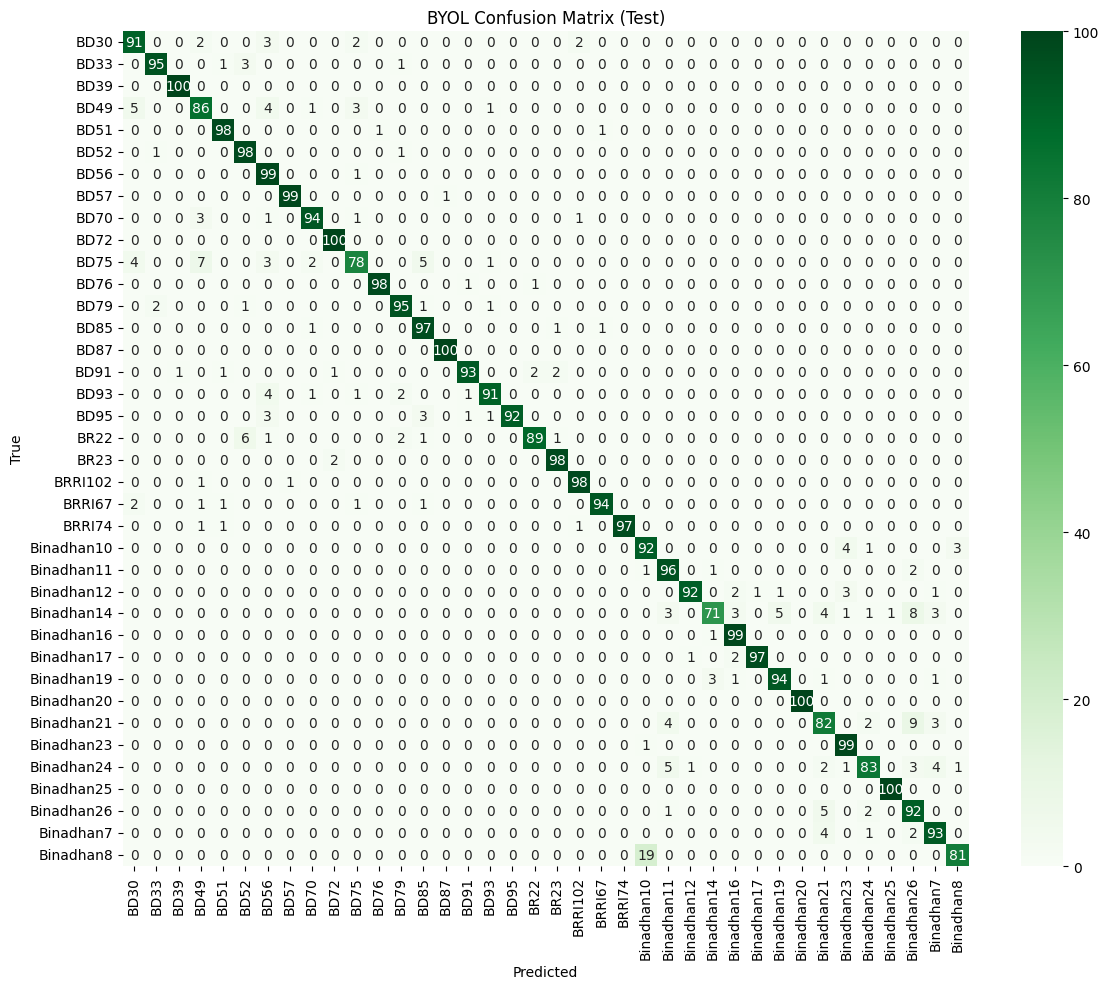

In [9]:
# === BYOL Part 8: Final Test Report + Confusion Matrix ===

# reload fresh model with best weights (EMA snapshot if enabled)
enc_eval = EncoderBYOL(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
enc_eval.load_state_dict(torch.load(os.path.join(SAVE_DIR, "byol_encoder.pth"), map_location=DEVICE))
sup_model_byol = SupModelBYOL(enc_eval, num_classes_byol).to(DEVICE)
sup_model_byol.load_state_dict(torch.load(os.path.join(SAVE_DIR, "byol_finetune_best.pt"), map_location=DEVICE))
sup_model_byol.eval()

y_true_b, y_pred_b = [], []
with torch.no_grad():
    for x,y in test_loader_sup_byol:
        x = x.to(DEVICE, non_blocking=True)
        logits = (sup_model_byol(x) + sup_model_byol(torch.flip(x, dims=[3])))/2 if USE_TTA else sup_model_byol(x)
        y_pred_b.extend(torch.argmax(logits, dim=1).cpu().numpy())
        y_true_b.extend(y.numpy())

print("\n=== BYOL -> Finetune: Held-out Test ===")
print(classification_report(y_true_b, y_pred_b, target_names=sup_test_ds_byol.classes, digits=4))

cm_b = confusion_matrix(y_true_b, y_pred_b)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens',
            xticklabels=sup_test_ds_byol.classes, yticklabels=sup_test_ds_byol.classes)
plt.title("BYOL Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_confusion_matrix.png"), dpi=150)
plt.show()


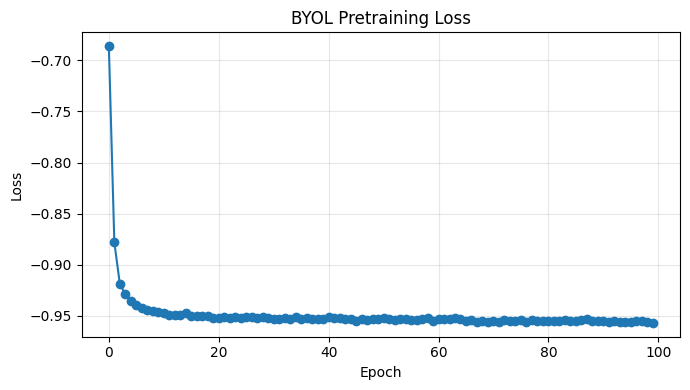

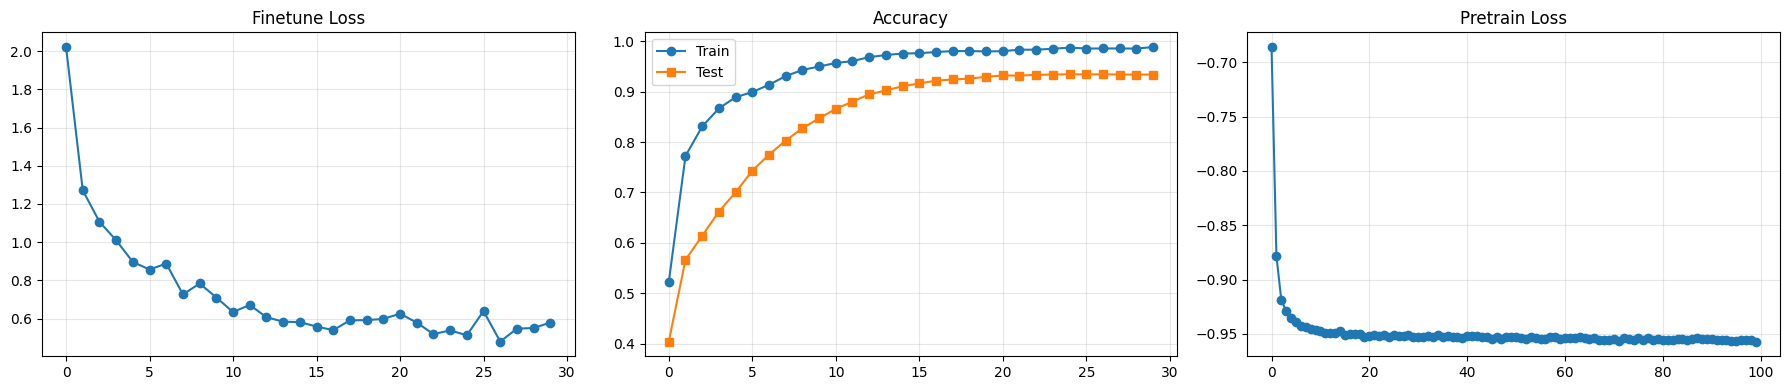

In [10]:
# === BYOL Part 9: Curves ===

plt.figure(figsize=(7,4))
plt.plot(byol_loss_hist, marker='o')
plt.title("BYOL Pretraining Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_pretrain_loss.png"), dpi=150); plt.show()

fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0].plot(ft_loss_hist_byol, marker='o'); ax[0].set_title("Finetune Loss"); ax[0].grid(True, alpha=0.3)
ax[1].plot(ft_acc_hist_byol, marker='o', label='Train'); ax[1].plot(val_acc_hist_byol, marker='s', label='Test'); ax[1].legend(); ax[1].set_title("Accuracy"); ax[1].grid(True, alpha=0.3)
ax[2].plot(byol_loss_hist, marker='o'); ax[2].set_title("Pretrain Loss"); ax[2].grid(True, alpha=0.3)
plt.tight_layout(); fig.savefig(os.path.join(SAVE_DIR, "byol_training_curves.png"), dpi=150); plt.show()


In [11]:
# === BYOL Part 10: Collect probabilities/preds ===

import numpy as np
sup_model_byol.eval()
class_names_byol = sup_test_ds_byol.classes
num_classes_byol = len(class_names_byol)

all_probs_b, all_preds_b, all_true_b = [], [], []
with torch.no_grad():
    for x,y in test_loader_sup_byol:
        x = x.to(DEVICE, non_blocking=True)
        logits = (sup_model_byol(x) + sup_model_byol(torch.flip(x, dims=[3])))/2 if USE_TTA else sup_model_byol(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs_b.append(probs); all_preds_b.append(preds); all_true_b.append(y.numpy())

y_prob_b = np.concatenate(all_probs_b, 0)
y_pred_b = np.concatenate(all_preds_b, 0)
y_true_b = np.concatenate(all_true_b, 0)

print("Shapes:", y_prob_b.shape, y_pred_b.shape, y_true_b.shape)


Shapes: (3800, 38) (3800,) (3800,)


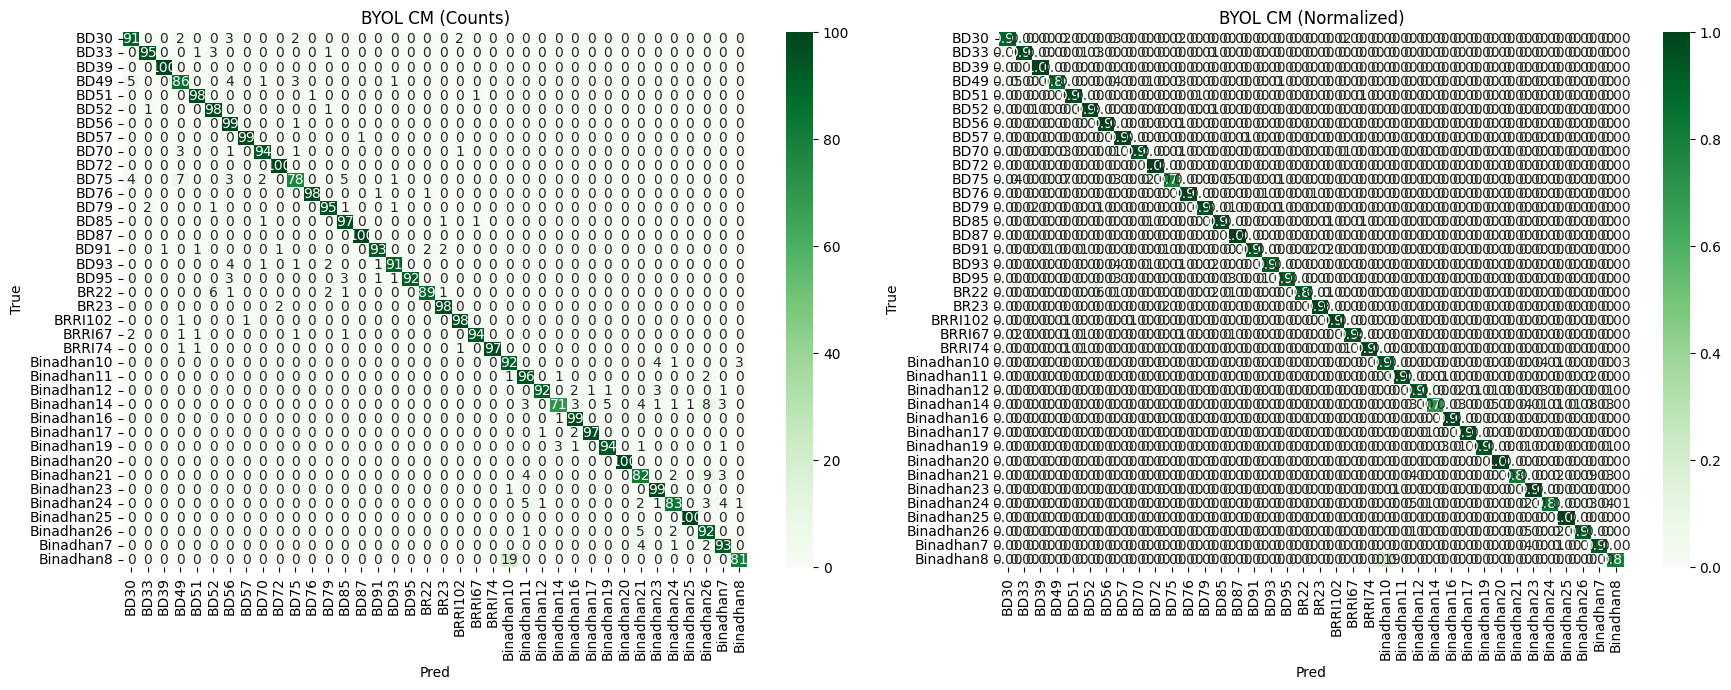

In [12]:
# === BYOL Part 11: Confusion Matrix (counts + normalized) ===

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_b, y_pred_b, labels=list(range(num_classes_byol)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1,2, figsize=(18,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names_byol, yticklabels=class_names_byol)
axes[0].set_title("BYOL CM (Counts)"); axes[0].set_xlabel("Pred"); axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=class_names_byol, yticklabels=class_names_byol, vmin=0, vmax=1)
axes[1].set_title("BYOL CM (Normalized)"); axes[1].set_xlabel("Pred"); axes[1].set_ylabel("True")

plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_cm_counts_norm.png"), dpi=150); plt.show()


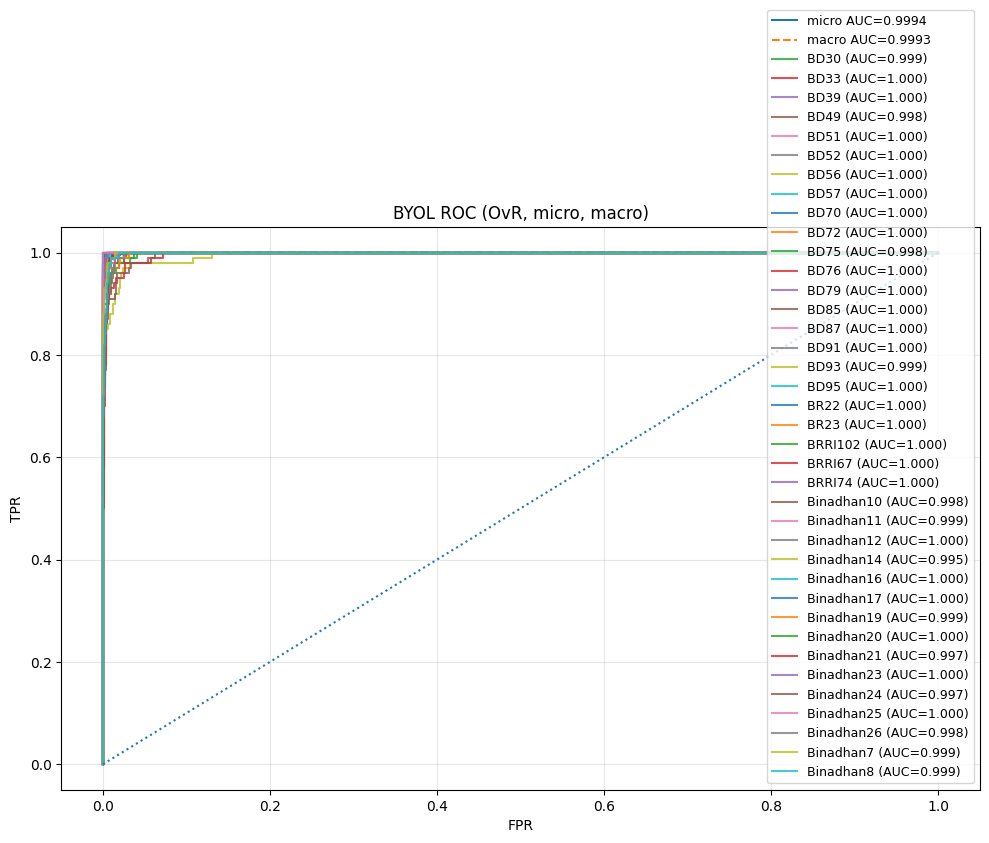

In [13]:
# === BYOL Part 12: ROC & AUC (OvR + micro/macro) ===

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

y_true_bin_b = label_binarize(y_true_b, classes=list(range(num_classes_byol)))
fpr_b, tpr_b, roc_auc_b = {}, {}, {}

for c in range(num_classes_byol):
    fpr_b[c], tpr_b[c], _ = roc_curve(y_true_bin_b[:,c], y_prob_b[:,c])
    roc_auc_b[c] = auc(fpr_b[c], tpr_b[c])

fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true_bin_b.ravel(), y_prob_b.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

all_fpr = np.unique(np.concatenate([fpr_b[c] for c in range(num_classes_byol)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(num_classes_byol):
    mean_tpr += np.interp(all_fpr, fpr_b[c], tpr_b[c])
mean_tpr /= num_classes_byol
roc_auc_b["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr_b["micro"], tpr_b["micro"], label=f"micro AUC={roc_auc_b['micro']:.4f}")
plt.plot(all_fpr, mean_tpr, '--', label=f"macro AUC={roc_auc_b['macro']:.4f}")
for c in range(num_classes_byol):
    plt.plot(fpr_b[c], tpr_b[c], alpha=0.8, label=f"{class_names_byol[c]} (AUC={roc_auc_b[c]:.3f})")
plt.plot([0,1],[0,1],':')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("BYOL ROC (OvR, micro, macro)")
plt.legend(loc="lower right", fontsize=9); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_roc.png"), dpi=150); plt.show()


K-Means (BYOL) -> ARI 0.6006 | NMI 0.7829 | Sil 0.1364
t-SNE (BYOL)...


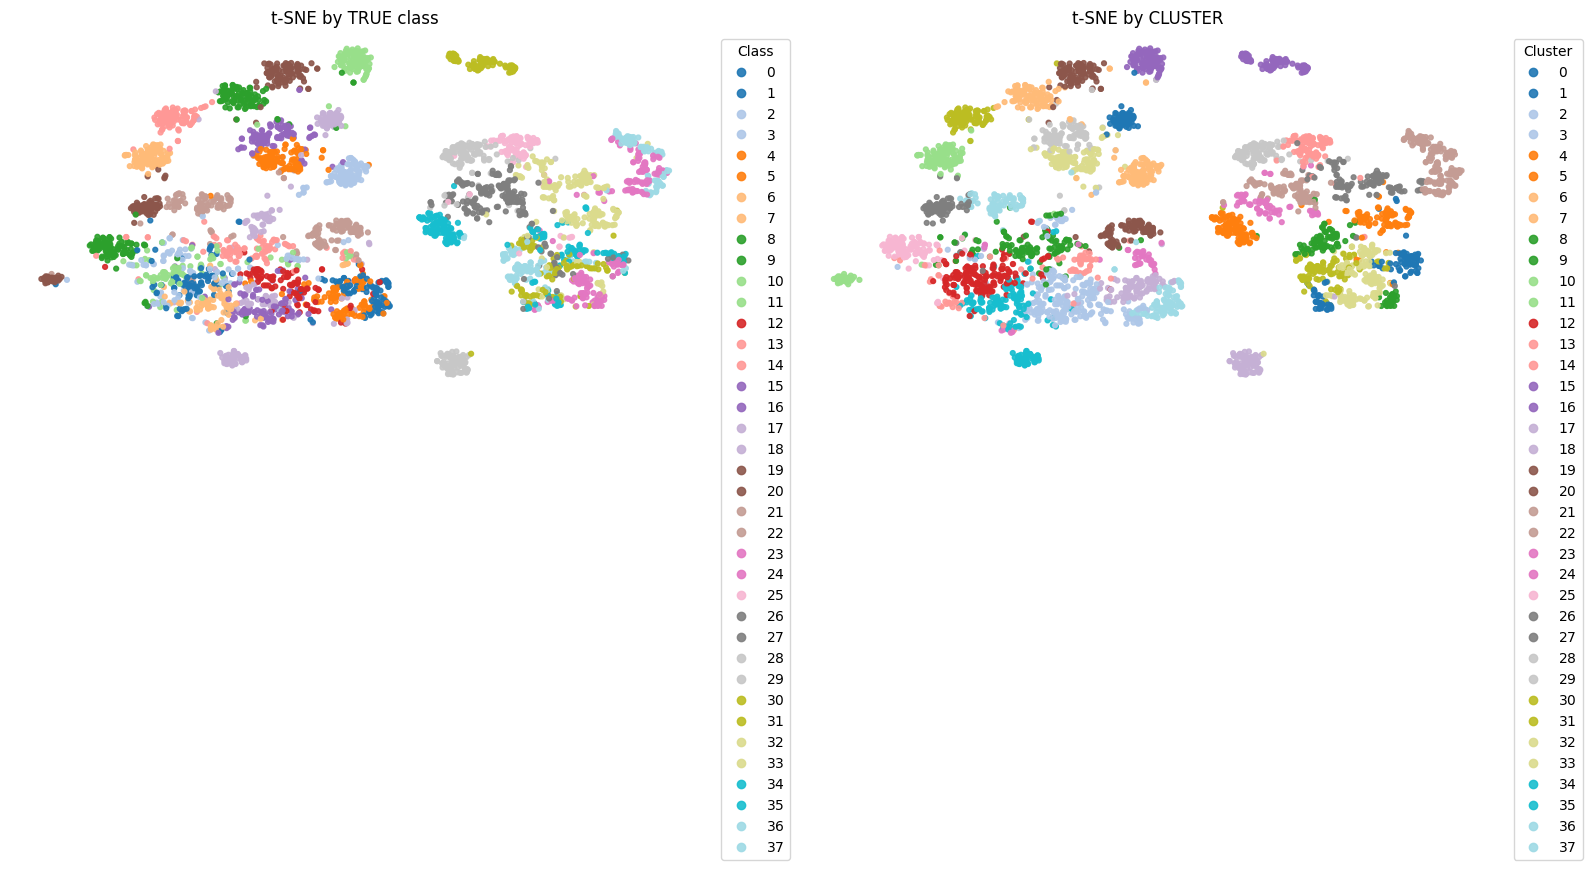

In [14]:
# === BYOL Part 13: Clustering (KMeans + t-SNE) ===

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
import numpy as np

@torch.no_grad()
def extract_feats(model, loader, device):
    model.eval(); feats=[]; labels=[]
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        f = model.encoder(x)
        feats.append(f.cpu().numpy()); labels.append(y.numpy())
    return np.concatenate(feats,0), np.concatenate(labels,0)

features_b, labels_b = extract_feats(sup_model_byol, test_loader_sup_byol, DEVICE)
features_b = features_b / (np.linalg.norm(features_b, axis=1, keepdims=True) + 1e-9)
kmeans = KMeans(n_clusters=num_classes_byol, n_init=20, random_state=SEED)
clusters_b = kmeans.fit_predict(features_b)

ari = adjusted_rand_score(labels_b, clusters_b)
nmi = normalized_mutual_info_score(labels_b, clusters_b)
sil = silhouette_score(features_b, clusters_b)
print(f"K-Means (BYOL) -> ARI {ari:.4f} | NMI {nmi:.4f} | Sil {sil:.4f}")

print("t-SNE (BYOL)...")
tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(labels_b)//20)), init='pca', random_state=SEED)
emb2d = tsne.fit_transform(features_b)

fig, axes = plt.subplots(1,2, figsize=(16,7))
s1 = axes[0].scatter(emb2d[:,0], emb2d[:,1], c=labels_b, s=12, alpha=0.9, cmap='tab20')
axes[0].set_title("t-SNE by TRUE class"); axes[0].axis('off')
axes[0].legend(*s1.legend_elements(num=num_classes_byol), title="Class", bbox_to_anchor=(1.02,1), loc='upper left')

s2 = axes[1].scatter(emb2d[:,0], emb2d[:,1], c=clusters_b, s=12, alpha=0.9, cmap='tab20')
axes[1].set_title("t-SNE by CLUSTER"); axes[1].axis('off')
axes[1].legend(*s2.legend_elements(num=num_classes_byol), title="Cluster", bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_tsne.png"), dpi=150); plt.show()


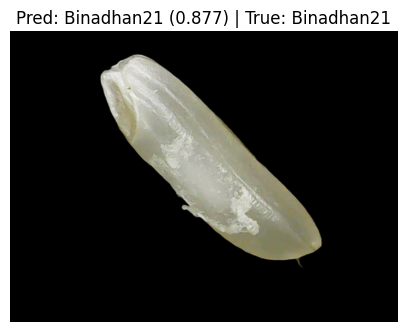

Top-k:
          Binadhan21: 0.8768
          Binadhan14: 0.0666
           Binadhan7: 0.0346
          Binadhan24: 0.0109
          Binadhan25: 0.0044


In [15]:
# === BYOL Part 14: Single-Image Validation Demo ===

from PIL import Image
img_path = None  # set a path or leave None to sample from test

if img_path is None:
    import random
    rnd = random.choice(range(len(test_sup_byol)))
    raw_path, true_lbl = sup_test_ds_byol.samples[test_idx_byol[rnd]]
    rgb_img = Image.open(raw_path).convert("RGB")
    x = eval_tf_byol(rgb_img).unsqueeze(0).to(DEVICE)
else:
    rgb_img = Image.open(img_path).convert("RGB")
    x = eval_tf_byol(rgb_img).unsqueeze(0).to(DEVICE)
    true_lbl = None

sup_model_byol.eval()
with torch.no_grad():
    probs = F.softmax(((sup_model_byol(x)+sup_model_byol(torch.flip(x,dims=[3])))/2) if USE_TTA else sup_model_byol(x), dim=1)[0].cpu().numpy()
topk = min(5, len(class_names_byol))
order = np.argsort(-probs)[:topk]

plt.figure(figsize=(5,5)); plt.imshow(rgb_img); plt.axis('off')
title = f"Pred: {class_names_byol[order[0]]} ({probs[order[0]]:.3f})"
if true_lbl is not None: title += f" | True: {class_names_byol[true_lbl]}"
plt.title(title); plt.show()

print("Top-k:")
for i in order: print(f"{class_names_byol[i]:>20s}: {probs[i]:.4f}")


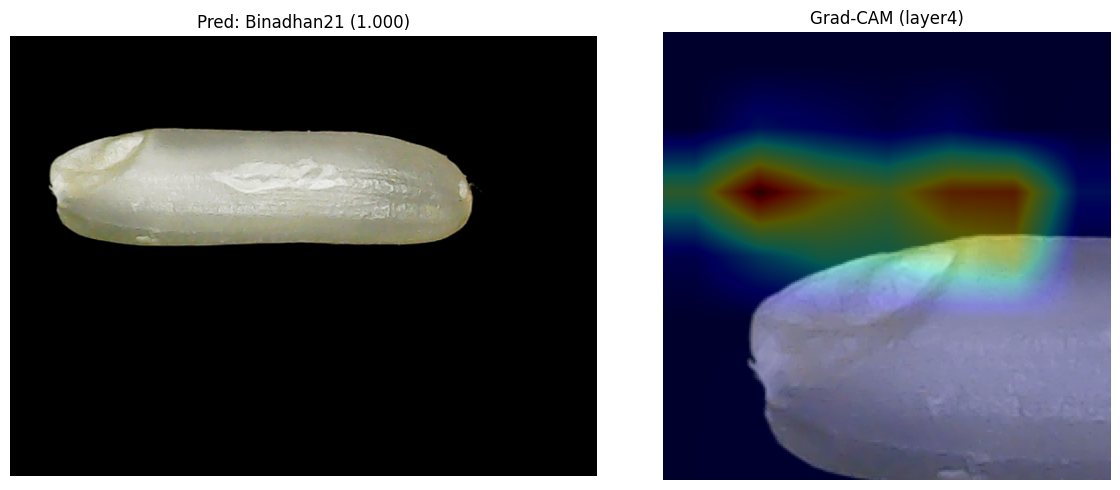

In [16]:
# === BYOL Part 15: Grad-CAM (single image) ===

import numpy as np
from PIL import Image

class GradCAM:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model; self.target_module = target_module
        self.activations=None; self.gradients=None
        self.fwd = target_module.register_forward_hook(self._fh)
        self.bwd = target_module.register_full_backward_hook(self._bh)
    def _fh(self,m,i,o): self.activations=o.detach()
    def _bh(self,m,gi,go): self.gradients=go[0].detach()
    def remove(self): self.fwd.remove(); self.bwd.remove()
    def generate(self, logits, class_idx):
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        B,_,H,W = cam.shape
        cam = cam.view(B,-1); cam -= cam.min(dim=1, keepdim=True).values
        cam /= (cam.max(dim=1, keepdim=True).values + 1e-9)
        return cam.view(B,1,H,W)

def get_target_conv_module_byol(m):  # ResNet50 layer4
    return m.encoder.backbone[7]

gradcam_img_path = None
if gradcam_img_path is None:
    import random
    rnd = random.choice(range(len(test_sup_byol)))
    raw_path, true_lbl = sup_test_ds_byol.samples[test_idx_byol[rnd]]
    rgb_img = Image.open(raw_path).convert("RGB")
    x = eval_tf_byol(rgb_img).unsqueeze(0).to(DEVICE)
else:
    rgb_img = Image.open(gradcam_img_path).convert("RGB"); x = eval_tf_byol(rgb_img).unsqueeze(0).to(DEVICE)
    true_lbl = None

sup_model_byol.eval()
target_module = get_target_conv_module_byol(sup_model_byol)
engine = GradCAM(sup_model_byol, target_module)

with torch.enable_grad():
    x.requires_grad_(True)
    logits = sup_model_byol(x)  # no TTA for CAM
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    sup_model_byol.zero_grad(set_to_none=True)
    logits[0, pred_idx].backward()
    cam = engine.generate(logits, pred_idx)[0,0]; engine.remove()
cam_up = F.interpolate(cam[None,None], size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(rgb_img); plt.axis('off'); plt.title(f"Pred: {class_names_byol[pred_idx]} ({probs[pred_idx]:.3f})")
plt.subplot(1,2,2); plt.imshow(rgb_img); plt.imshow(cam_up, cmap='jet', alpha=0.35); plt.axis('off'); plt.title("Grad-CAM (layer4)")
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "byol_gradcam_overlay.png"), dpi=150); plt.show()


In [17]:
# === BYOL Part 15A: Grad-CAM per-class (correct & incorrect) ===

import os, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

OUT_DIR = os.path.join(SAVE_DIR, "byol_gradcam_per_class")
os.makedirs(OUT_DIR, exist_ok=True)
N_PER_CLASS_CORRECT = 1
N_PER_CLASS_INCORRECT = 1

class GradCAMMini:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model=model; self.t=target_module
        self.a=None; self.g=None
        self.f=self.t.register_forward_hook(lambda m,i,o: setattr(self,'a',o.detach()))
        self.b=self.t.register_full_backward_hook(lambda m,gi,go: setattr(self,'g',go[0].detach()))
    def remove(self): self.f.remove(); self.b.remove()
    def generate(self, idx):
        w = self.g.mean(dim=(2,3), keepdim=True)
        cam = (w*self.a).sum(dim=1, keepdim=True); cam = F.relu(cam)
        B=cam.shape[0]; cam=cam.view(B,-1); cam-=cam.min(dim=1,keepdim=True).values; cam/= (cam.max(dim=1,keepdim=True).values+1e-9)
        return cam.view(B,1,self.a.shape[2], self.a.shape[3])

target_mod = sup_model_byol.encoder.backbone[7]
cands_ok = {c:[] for c in range(num_classes_byol)}
cands_bad= {c:[] for c in range(num_classes_byol)}
sup_model_byol.eval()
test_samples = [sup_test_ds_byol.samples[i] for i in test_idx_byol]

for idx_batch,(xb,yb) in enumerate(tqdm(test_loader_sup_byol, desc="Scanning test set")):
    for j in range(xb.size(0)):
        gid = idx_batch*test_loader_sup_byol.batch_size + j
        if gid>=len(test_samples): break
        raw_path, true_lbl = test_samples[gid]
        x = xb[j:j+1].to(DEVICE, non_blocking=True)
        with torch.no_grad():
            pr = F.softmax(sup_model_byol(x), dim=1)[0].cpu().numpy()
        pred = int(np.argmax(pr)); conf=float(pr[pred])
        (cands_ok if pred==true_lbl else cands_bad)[true_lbl].append((conf, raw_path, true_lbl, pred))

for c in range(num_classes_byol):
    cands_ok[c].sort(key=lambda t:-t[0]); cands_bad[c].sort(key=lambda t:-t[0])

for c in range(num_classes_byol):
    # correct
    sel = cands_ok[c][:N_PER_CLASS_CORRECT] if N_PER_CLASS_CORRECT is not None else cands_ok[c]
    for k,(conf,raw_path,true_lbl,pred) in enumerate(sel):
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf_byol(rgb).unsqueeze(0).to(DEVICE); x.requires_grad_(True)
        cam = GradCAMMini(sup_model_byol, target_mod)
        logits = sup_model_byol(x); sup_model_byol.zero_grad(set_to_none=True); logits[0,pred].backward()
        m = cam.generate(pred)[0,0]; cam.remove()
        m_up = F.interpolate(m[None,None], size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off'); plt.title(f"TRUE={class_names_byol[true_lbl]} | PRED={class_names_byol[pred]} ({conf:.3f}) [correct]")
        plt.subplot(1,2,2); plt.imshow(rgb); plt.imshow(m_up, cmap='jet', alpha=0.35); plt.axis('off'); plt.title("Grad-CAM")
        plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"class{c:02d}_correct_{k}.png"), dpi=150); plt.close()

    # incorrect
    sel = cands_bad[c][:N_PER_CLASS_INCORRECT] if N_PER_CLASS_INCORRECT is not None else cands_bad[c]
    for k,(conf,raw_path,true_lbl,pred) in enumerate(sel):
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf_byol(rgb).unsqueeze(0).to(DEVICE); x.requires_grad_(True)
        cam = GradCAMMini(sup_model_byol, target_mod)
        logits = sup_model_byol(x); sup_model_byol.zero_grad(set_to_none=True); logits[0,pred].backward()
        m = cam.generate(pred)[0,0]; cam.remove()
        m_up = F.interpolate(m[None,None], size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off'); plt.title(f"TRUE={class_names_byol[true_lbl]} | PRED={class_names_byol[pred]} ({conf:.3f}) [incorrect]")
        plt.subplot(1,2,2); plt.imshow(rgb); plt.imshow(m_up, cmap='jet', alpha=0.35); plt.axis('off'); plt.title("Grad-CAM")
        plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"class{c:02d}_incorrect_{k}.png"), dpi=150); plt.close()

print(f"Saved per-class Grad-CAM overlays to: {OUT_DIR}")


Scanning test set: 100%|██████████| 60/60 [00:29<00:00,  2.03it/s]


Saved per-class Grad-CAM overlays to: ./byol_gradcam_per_class
